In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import shap
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm, trange
import numbers

In [3]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","strobl_simulation")
today_str = datetime.today().strftime("%Y%m%d")

We want to assess the predictive performance of the different RF models on the strobl dataset and plot the results similar to toy dataset from HS paper.

## Define functions

In [5]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [27]:
# Get y_true for Strobl simulation
def y_true_strobl(X):
    if X.ndim<=2:
        y_true = (X[:,:,1]-1)
        return y_true.reshape(X.shape[1], 1)
    else:
        y_true = (X[:,:,1]-1)
        return y_true.reshape(X.shape[0], X.shape[1], 1)

In [39]:
def run_strobl_simulation(n=120, M=1, relevance_power=0.15, cv=10, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)
    
    # y_preds_null_RF = []
    # y_preds_null_hsRF = []
    # y_preds_null_hsRF_smSHAP = []
    # y_preds_null_hsRF_mseratio = []
    # y_preds_power_RF = []
    # y_preds_power_hsRF = []
    # y_preds_power_hsRF_smSHAP = []
    # y_preds_power_hsRF_mseratio = []
    
    #Null simulation
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state)

    #Power simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_state)
    
    # Test data for plotting
    X_test, y_n_test = simulate_data_strobl(n=n, M=M, relevance=0)
    y_p_true = y_true_strobl(X_test.copy())

    i = 0
    grid = {"HS_lambda":[0.1,1,5,10,20,50,100]}

    # Null RF: 
    null_rf = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False)
    null_rf.fit(X_null[i,:,:], y_null[:,i])
    y_pred_null_rf = null_rf.predict(X_test[i,:,:])

    # Null hsRF: 
    null_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True)
    grid_cv_HS = GridSearchCV_scratch(null_rfHS, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)
    y_pred_null_rfHS = null_rfHS.predict(X_test[i,:,:])

    # Null hsRF smooth SHAP: 
    null_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True)
    grid_cv_HSsmSH = GridSearchCV_scratch(null_rfHSsmSH, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)
    y_pred_null_rfHSsmSH = null_rfHSsmSH.predict(X_test[i,:,:])

    # Null hsRF nodewise MSE: 
    null_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio")
    grid_cv_HSmse = GridSearchCV_scratch(null_rfHSmse, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)
    y_pred_null_rfHSmse = null_rfHSmse.predict(X_test[i,:,:])

    # Power: 
    power_rf = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False)
    power_rf.fit(X_power[i,:,:], y_power[:,i])
    y_pred_power_rf = power_rf.predict(X_test[i,:,:])

    # Power hsRF: 
    power_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True)
    grid_cv_HS_p = GridSearchCV_scratch(power_rfHS, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)
    y_pred_power_rfHS = power_rfHS.predict(X_test[i,:,:])

    # Power hsRF smooth SHAP: 
    power_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True)
    grid_cv_HSsmSH_p = GridSearchCV_scratch(power_rfHSsmSH, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)
    y_pred_power_rfHSsmSH = power_rfHSsmSH.predict(X_test[i,:,:])

    # Power hsRF nodewise MSE: 
    power_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio")
    grid_cv_HSmse_p = GridSearchCV_scratch(power_rfHSmse, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)
    y_pred_power_rfHSmse = power_rfHSmse.predict(X_test[i,:,:])

    results = {
        "simulation_params":
            {"n": n, 
            "M": M, 
            "relevance_power": relevance_power, 
            "cv": cv,
            "random_seed": random_seed},
        "data": 
            {"train":{
                "X_null": X_null,
                "y_null": y_null,
                "X_power": X_power,
                "y_power": y_power},
            "test": {
                "X": X_test,
                "y_null_true": y_n_test,
                "y_power_true": y_p_true
            }},
        "Null":
            {"rf":{
                "model": null_rf,
                "y_pred": y_pred_null_rf},
            "HSrf":{
                "model": null_rfHS,
                "y_pred": y_pred_null_rfHS,
                "grid_cv": grid_cv_HS},
            "HSrfsmSH":{
                "model": null_rfHSsmSH,
                "y_pred": y_pred_null_rfHSsmSH,
                "grid_cv": grid_cv_HSsmSH},
            "HSrfmse":{
                "model": null_rfHSmse,
                "y_pred": y_pred_null_rfHSmse,
                "grid_cv": grid_cv_HSmse},
            },
        "Power":
            {"rf":{
                "model": power_rf,
                "y_pred": y_pred_power_rf},
            "HSrf":{
                "model": power_rfHS,
                "y_pred": y_pred_power_rfHS,
                "grid_cv": grid_cv_HS_p},
            "HSrfsmSH":{
                "model": power_rfHSsmSH,
                "y_pred": y_pred_power_rfHSsmSH,
                "grid_cv": grid_cv_HSsmSH_p},
            "HSrfmse":{
                "model": power_rfHSmse,
                "y_pred": y_pred_power_rfHSmse,
                "grid_cv": grid_cv_HSmse_p},
            }}
    
    return results


In [ ]:
#results_strobl = run_strobl_simulation(n=120, M=1, relevance_power=0.15, cv=10, random_seed=42)

In [41]:
import pickle

with open(f'{data_path}/performance_strobl.pickle', 'wb') as handle:
    pickle.dump(results_strobl, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [83]:
X_test = results_strobl.get("data").get("test").get("X")
y_null_true = results_strobl.get("data").get("test").get("y_null_true").reshape(120,)
y_pred_rf_null = results_strobl.get("Null").get("rf").get("y_pred")
y_pred_HSrf_null = results_strobl.get("Null").get("HSrf").get("y_pred")
y_pred_HSrfsmSH_null = results_strobl.get("Null").get("HSrfsmSH").get("y_pred")
y_pred_HSrfMSE_null = results_strobl.get("Null").get("HSrfmse").get("y_pred")

y_power_true = results_strobl.get("data").get("test").get("y_power_true").reshape(120,)
y_pred_rf_power = results_strobl.get("Power").get("rf").get("y_pred")
y_pred_HSrf_power = results_strobl.get("Power").get("HSrf").get("y_pred")
y_pred_HSrfsmSH_power = results_strobl.get("Power").get("HSrfsmSH").get("y_pred")
y_pred_HSrfMSE_power = results_strobl.get("Power").get("HSrfmse").get("y_pred")

In [96]:
def plot_stroblX2(X_test, y_pred_rf, y_pred_rfHS, y_pred_rfHSsm, y_pred_rfHSmse, y_true, case="Null", ax=None):

    # if ax == None:
    #     ax = plt.axes()

    #ax.plot(X_test, y_test, 'o', color='black', ms=4, alpha=0.5, markeredgewidth=0)    
    sns.lineplot(x=X_test[0,:,1], y=y_true, label='Groundtruth', color='black', lw=3)    
    sns.lineplot(x=X_test[0,:,1], y=y_pred_rf, label='CART', color="skyblue", alpha=0.5, lw=4)
    sns.lineplot(x=X_test[0,:,1], y=y_pred_rfHS, label='hsCART', color='#ff4b33', alpha=0.5, lw=4)
    sns.lineplot(x=X_test[0,:,1], y=y_pred_rfHSsm, label='hsSmSHAP_RF', color='green', alpha=0.5, lw=4)
    sns.lineplot(x=X_test[0,:,1], y=y_pred_rfHSmse, label='hsMSE_RF', color='red', alpha=0.5, lw=4)
    ax.set_xlabel('X2')
    ax.set_ylabel('Y')
    
    if case=="Null":
        ax.set_title('Null case')
    else:
        ax.set_title('Power case')
    
    pass


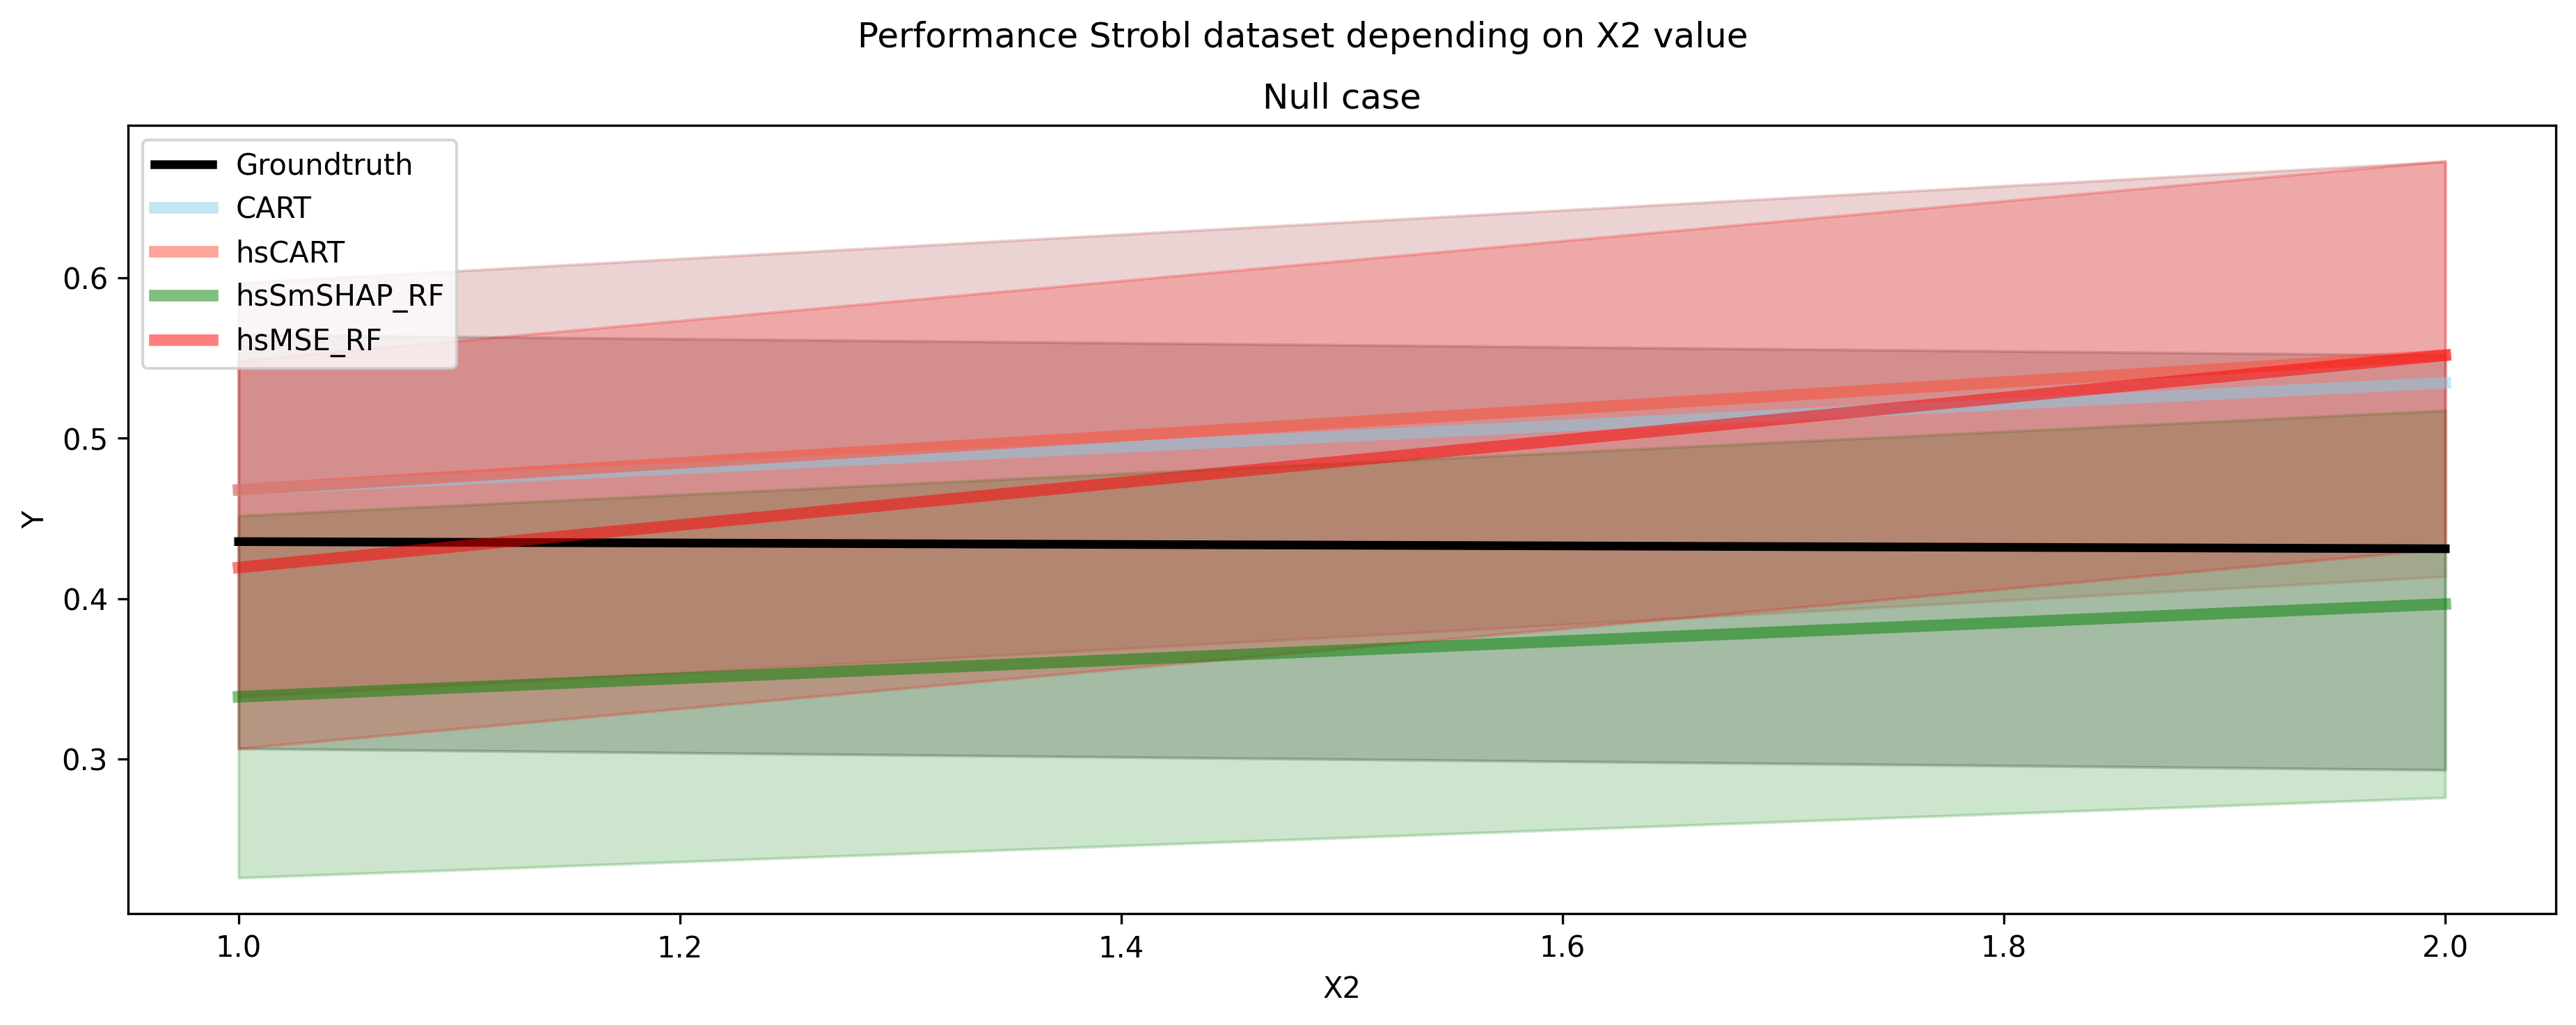

In [97]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
fig.suptitle("Performance Strobl dataset depending on X2 value")

plot_stroblX2(X_test, y_pred_rf_null, y_pred_HSrf_null, y_pred_HSrfsmSH_null, y_pred_HSrfMSE_null, y_null_true, case="Null", ax=axs)

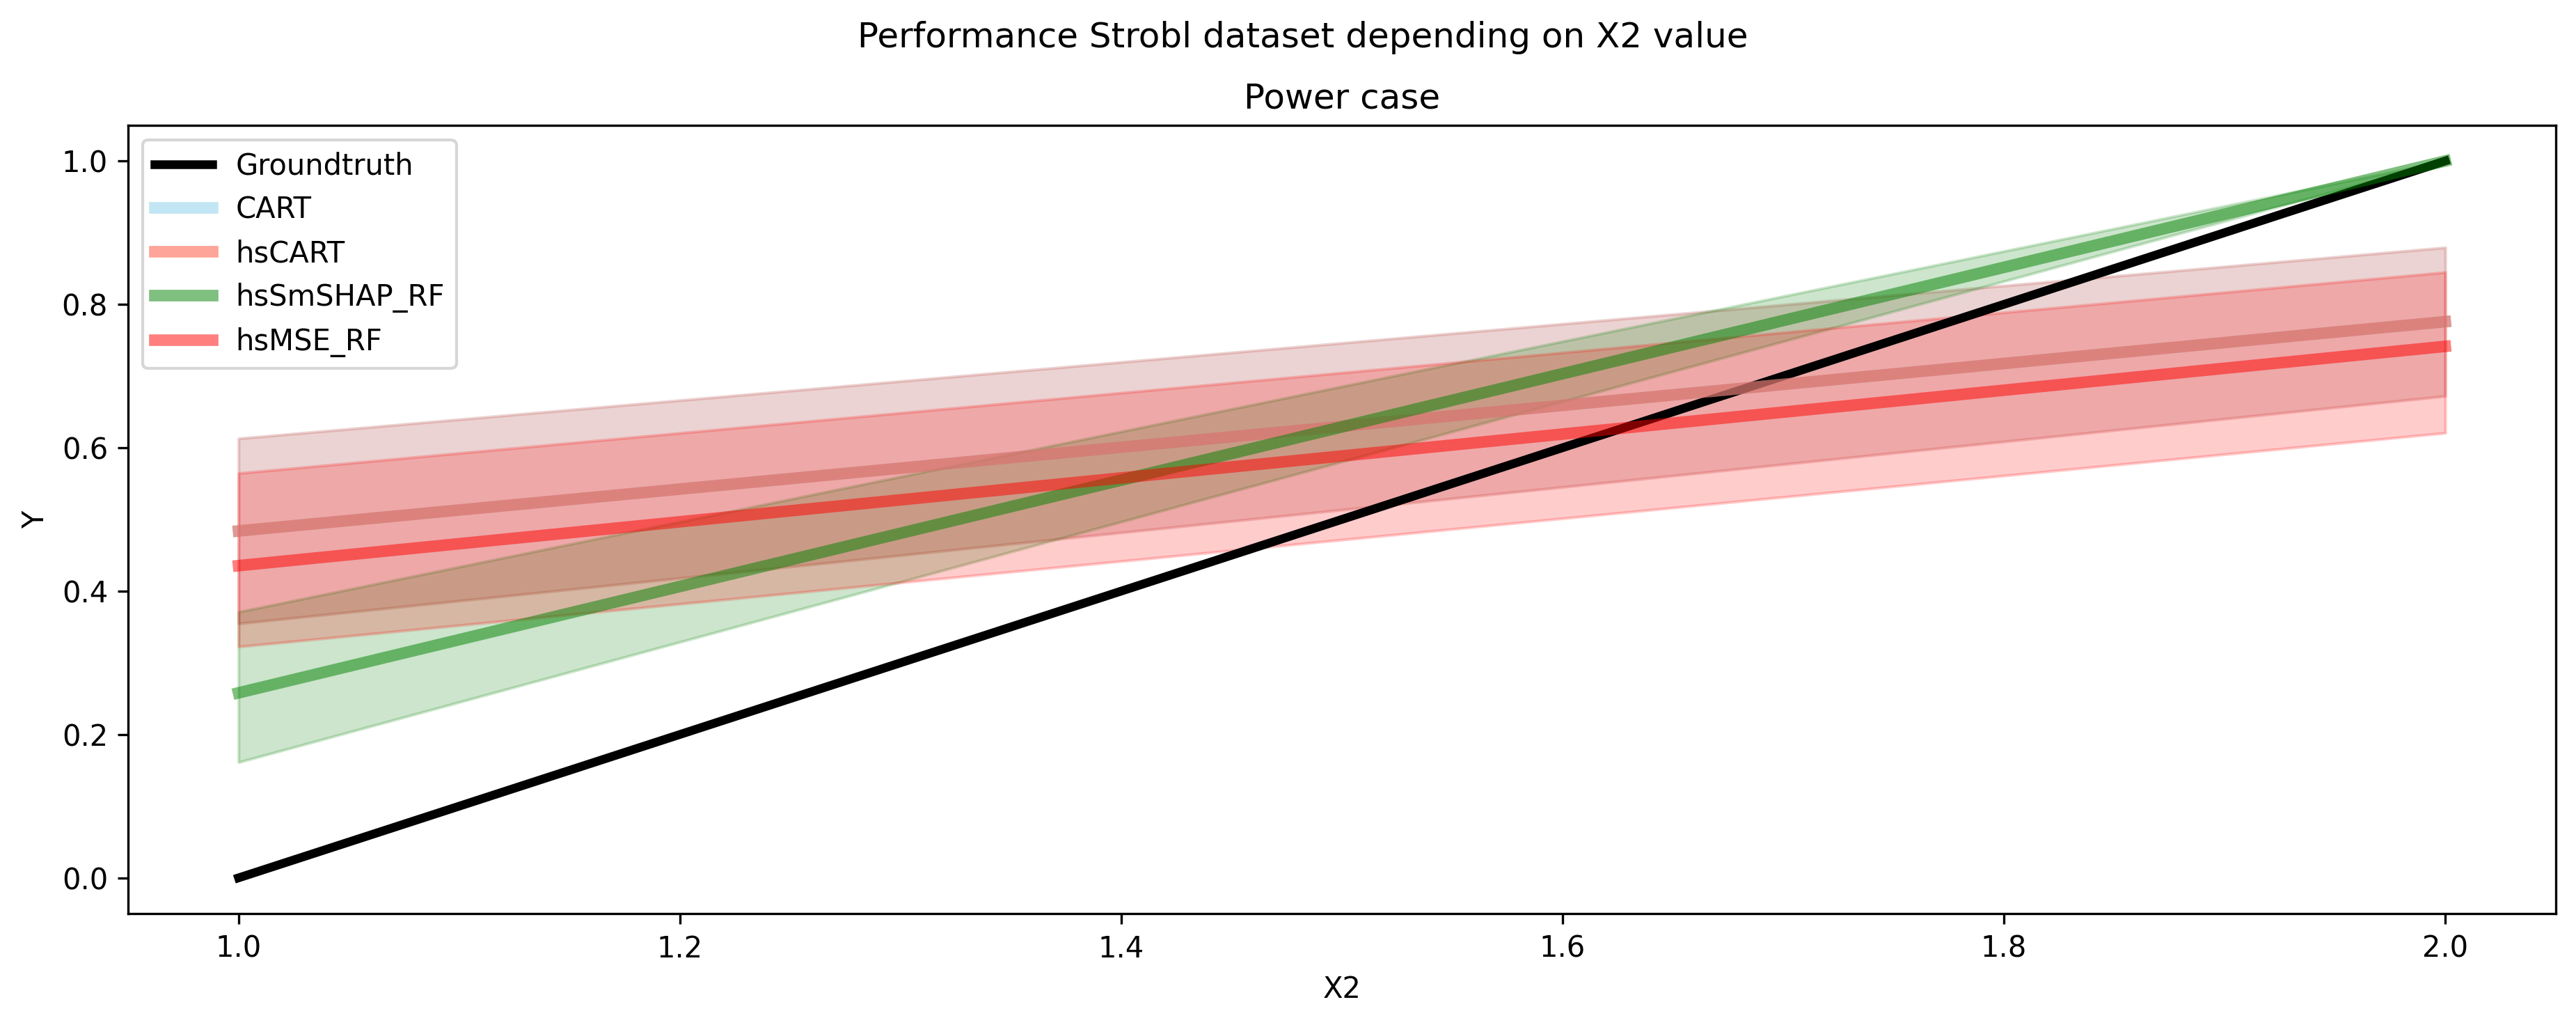

In [98]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
fig.suptitle("Performance Strobl dataset depending on X2 value")

plot_stroblX2(X_test, y_pred_rf_power, y_pred_HSrf_power, y_pred_HSrfsmSH_power, y_pred_HSrfMSE_power, y_power_true, case="power", ax=axs)